<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/35_4_GAN_MNIST_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание 1. На 3 балла:**

1. Ваша задача, используя датасет MNIST (из набора датасетов Tensorflow) научить GAN генерировать цифры.

2. Добейтесь хорошего качества генерации.

**Задание 2. На 4 балла:**

1. Ваша задача, используя датасет MNIST Fashion (из набора датасетов Tensorflow) научить GAN генерировать образцы одежды, соответственно.

2. Добейтесь хорошего качества генерации.

In [1]:
from random import randint
from keras.datasets import fashion_mnist

from PIL import Image
import imageio
import cv2
from keras.preprocessing.image import img_to_array

import numpy as np
import os
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# обучающие данные
print(train_images.shape)
print(len(train_images))
print(train_images.dtype)
print(train_images)

(60000, 28, 28)
60000
uint8
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [4]:
# тестовые данные
print(test_images.shape)
print(len(test_labels))
print(test_labels.dtype)
print(test_labels)

(10000, 28, 28)
10000
uint8
[9 2 1 ... 8 1 5]


In [5]:
# наименования меток
class_names = ['Футболка / топ', "Шорты", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

Номер метки изображения: 4
Наименование метки изображения: Плащ 



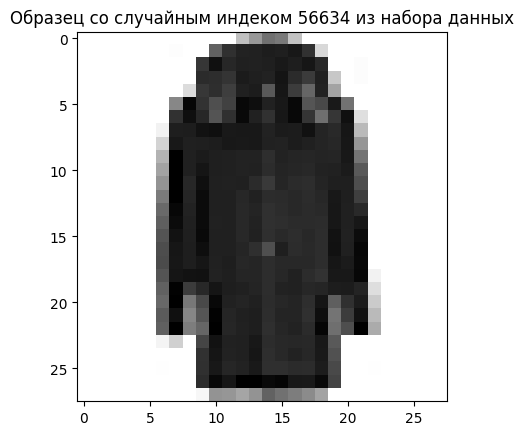

In [6]:
random_number = randint(0, len(train_labels))

digit = train_images[random_number]
fig, ax = plt.subplots(1,1)
print(f'Номер метки изображения: {train_labels[random_number]}')
print(f'Наименование метки изображения: {class_names[train_labels[random_number]]}', '\n')
ax.set_title(f'Образец со случайным индеком {random_number} из набора данных')
ax.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [7]:
# константы
SIZE = 28                  # линейный размер изображений (одно измерение)
INPUT_IMG = (SIZE, SIZE, 2) # размер входного изображений
BATCH_SIZE = 32             # размер пакета для обучения
LATENT_DIM = 100            # размерность латентного пространства

In [8]:
train_images = train_images.astype(float)
print(train_images.dtype)

train_images = (train_images - 27.5) / 27.5
X_train = np.array(train_images)

print(X_train.shape)

float64
(60000, 28, 28)


In [9]:
dataset=tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

In [10]:
def Generator():
    model = Sequential()
    model.add(Dense(SIZE*SIZE*2, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(Reshape(INPUT_IMG))
    # downsampling (понижающая дискретизация)
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*4, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(SIZE*4,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(tf.keras.layers.LeakyReLU())
    #upsampling (повышающая дискретизация)
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*4, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*4, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*2, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*2, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(SIZE, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(SIZE, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(2,4,strides = 1, padding = 'same',activation = 'tanh'))

    return model

In [11]:
generator = Generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1568)                │         156,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 28)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 28)          │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 28)          │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 56)          │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 56)            │          50,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 56)            │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 112)           │         100,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 112)           │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 4, 4, 112)           │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 8, 8, 112)           │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 112)           │             448 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 8, 8, 56)            │         100,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 56)          │          50,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 56)          │             2

 Total params: 1,138,146 (4.34 MB)

 Trainable params: 1,137,586 (4.34 MB)

 Non-trainable params: 560 (2.19 KB)

In [12]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(INPUT_IMG))
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*4,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

    return model

In [13]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 28)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 28)          │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 28)            │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 28)            │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 28)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 56)            │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 4, 4, 56)            │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 4, 4, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 2, 56)            │          50,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 2, 2, 56)            │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 2, 2, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 1, 112)           │         100,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 1, 1, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             113 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,841 (741.57 KB)

 Trainable params: 189,505 (740.25 KB)

 Non-trainable params: 336 (1.31 KB)

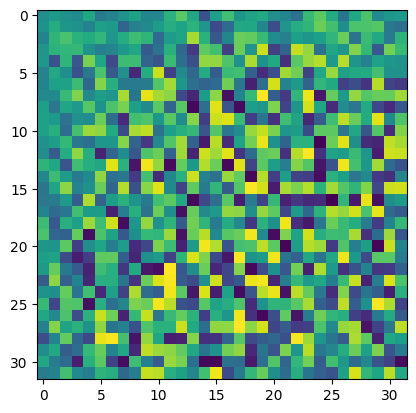

In [14]:
noise = np.random.normal(-1,1,(1,LATENT_DIM))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [15]:
optimizer_G = tf.keras.optimizers.RMSprop(learning_rate=.0001)
optimizer_D = tf.keras.optimizers.RMSprop(learning_rate=.0001)

# Этот метод возвращает вспомогательную функцию для вычисления перекрестных потерь энтропии
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [16]:
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


@tf.function
def train_steps(images):

    # генерируем шум на входе генератора
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Инициализируем GradientTape (градиентную ленту) для дискриминатора и генератор
    #  по отдельности, чтобы записать операции,
    # выполняемые во время прямого прохода, включающего автодифференцирование.
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        # Запустим прямой проход шума через генератор.
        # Операции применяемые каждым слоем к своим
        # входным данным будут записаны на GradientTape, как на ленту магнитофона.
        # Отсюда и название градиентной ленты.
        generated_images = generator(noise)

        # Также обеспечиваем прямой проход через дискриминатор для
        # для реальных и фейковых изображений
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        # расчитываем функции ошибок (значения потерь)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Используем gradient tape для автоматического извлечения градиентов
    # обучаемых переменных относительно потерь.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Выполним один шаг градиентного спуска, обновив
    # значение переменных минимизирующих потери.
    optimizer_G.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    # Вернем значения потерь для визуализации
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

In [17]:
import time
def train(epochs, dataset):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Время:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'],loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [18]:
G, D = train(5, dataset)


Эпоха : 1


ValueError: in user code:

    File "<ipython-input-16-f0c25695e5bf>", line 30, in train_steps  *
        real_output = discriminator(images)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 244, in _adjust_input_rank
        raise ValueError(

    ValueError: Exception encountered when calling Sequential.call().
    
    [1mInvalid input shape for input Tensor("Cast_1:0", shape=(32, 28, 28), dtype=float32). Expected shape (None, 28, 28, 2), but input has incompatible shape (32, 28, 28)[0m
    
    Arguments received by Sequential.call():
      • inputs=tf.Tensor(shape=(32, 28, 28), dtype=float32)
      • training=None
      • mask=None
